# Dog Breed Identification: DLNN Final Project
Ian Battin & Liam Schmid




In this project, we are tackling the Kaggle Competition: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/).

In this competition, you are given a dataset containing images of 120 different breeds of dogs. It is our job to classify images in the test set into these 120 different breeds.

Being an image based challenge, CNNs are the obvious choice. We will discuss the different strategies and optimizations we tried as well as provide all the code used at each step.

Then, we will do an analysis of the internal structure of our best model and try to figure out what it's "seeing".

## Preparing the data
The data is provided in two folders - train and test - where each file is an image. There is a labels.csv file which maps an image filename to a label (breed).

To prepare our data for use, we needed to move all of the images in the training set into seperate folders grouped by breed:

In [ ]:
import sys
import os
import shutil
import numpy as np
from pathlib import Path


if len(sys.argv) != 2:
    print("Usage: python PrepareData.py <labels_file>")

    
def generateIDMapping(labelsFile):
    idMap = {}

    with open(labelsFile) as f:
        for line in f:
            if line.rstrip() != 0 and line.rstrip() != "id,breed":
                id, breed = line.rstrip().split(
                    ',')[0], line.rstrip().split(',')[1]
                idMap[id] = breed
    return idMap


def makeBreedDirectories(idMap, source, dest):
    if os.path.exists(dest):
        shutil.rmtree(dest)

    for filename in os.listdir(source):
        id = filename.split('.')[0]
        breed = idMap[id]

        srcPath = source+"/"+filename
        destPath = dest+"/"+breed+"/"+filename

        path = Path(dest+"/"+breed)
        path.mkdir(parents=True, exist_ok=True)
        shutil.copyfile(srcPath, destPath)


def makeValidationDirectories():
    for dirname in os.listdir('train'):
        samples = np.asarray(os.listdir('train/'+dirname))
        valSamples = np.random.choice(samples, len(samples)//4, replace=False)

        if os.path.exists('validation/'+dirname):
            shutil.rmtree('validation/'+dirname)
        for sample in valSamples:
            path = Path('validation/'+dirname)
            path.mkdir(parents=True, exist_ok=True)

            shutil.move('train/'+dirname+'/'+sample,
                        'validation/'+dirname+'/'+sample)


def makeTestDirectory(source, dest):
    if os.path.exists(dest):
        shutil.rmtree(dest)

    dest = dest + "/images"
    path = Path(dest)
    path.mkdir(parents=True, exist_ok=True)

    for filename in os.listdir(source):
        srcPath = source+"/"+filename
        destPath = dest+"/"+filename
        shutil.copyfile(srcPath, destPath)


idMap = generateIDMapping('data/labels.csv')
makeBreedDirectories(idMap, 'data/train', 'train')
makeValidationDirectories()
makeTestDirectory('data/test', 'test')

This will generate a file structure which looks like the following:

In [ ]:
'''
train/
    affenpinscher/
        1a012faf98b32039adc17ee708bcb360.jpg
        1aa98488ce65f9b57b468ccde4f1cad8.jpg
        ...
    afghan_hound/
    african_hunting_dog/
    ...
    yorkshire_terrier/
validation/
    affenpinscher/
        1ee0c041d15647e3909625eba419f153.jpg
        10edc6f98c2423e4e195e09a86b0d292.jpg
        ...
    afghan_hound/
    african_hunting_dog/
    ...
    yorkshire_terrier/
test/
    images/
        0a0b97441050bba8e733506de4655ea1.jpg
        0a0f82d4557f70718efa26f8a8a7773f.jpg
        ...
'''

## Creating image generators
Now that our training data is set up, we can begin preparing for training our models.

First, we'll need to create image generators for our data:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def get_generators(train_dir_name, val_dir_name, test_dir_name):
    # All images will be rescaled by 1./255
    train_data_gen = ImageDataGenerator(rescale=1./255)
    val_data_gen = ImageDataGenerator(rescale=1./255)
    test_data_gen = ImageDataGenerator(rescale=1./255)

    train_generator = train_data_gen.flow_from_directory(
        train_dir_name,
        color_mode="rgb",
        target_size=(299, 299),
        batch_size=32,
        class_mode="categorical")
    val_generator = val_data_gen.flow_from_directory(
        val_dir_name,
        color_mode="rgb",
        target_size=(299, 299),
        batch_size=32,
        class_mode="categorical")
    test_generator = test_data_gen.flow_from_directory(
        test_dir_name,
        color_mode="rgb",
        target_size=(299, 299),
        batch_size=1,
        class_mode=None,
        shuffle=False)

    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break

    return train_generator, val_generator, test_generator

train_dir_name = 'train/'
val_dir_name = 'validation/'
test_dir_name = 'test/'

train_generator, val_generator, test_generator = get_generators(
        train_dir_name, val_dir_name, test_dir_name)

## Building our Model
We used many different types of models, I'll go in order of our techniques and incremental improvements made

### Unmodified InceptionV3
Our first test was to simply use the pretrained InceptionV3 model. This model was trained and tested using the ImageNet dataset, of which our dataset is a subset of. This means it should be able to already classify our 120 dog breeds. We simply added a Dense layer of 120 neurons to get an output dimension that matches 120 dog breeds.

In [ ]:
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import InceptionV3

def build_inception_model():
    convBase = InceptionV3(
        weights='imagenet', 
        include_top=True, 
        input_shape=(299, 299, 3))
    convBase.trainable = False

    model = models.Sequential()
    model.add(convBase)
    model.add(layers.Dense(120, activation='softmax'))

    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

model = build_inception_model()

Now lets train it and save it:

In [ ]:
def train_model(model, train_gen, val_gen, epochs=30, verbose=False):
    history = model.fit_generator(
        train_gen,
        steps_per_epoch=100,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=50,
        verbose=verbose)

    return history

train_model(model, train_generator, val_generator, 
    epochs=50, verbose=True)
model.save("./Inception.h5")

With this data, we can already see that it's doing decent, but not great. It's only reaching accuracies in the mid 70s, and validation accuracys in the mid 80s. Lets go ahead and generate predictions for our test set and submit to kaggle to see our score:

In [ ]:
def classify_images(model, label_map, test_generator, verbose=False):
    steps = test_generator.n

    predictions = model.predict_generator(
        test_generator,
        steps=steps,
        verbose=verbose)

    labels = sorted(list(label_map.keys()))
    
    with open("predictions.csv", 'w') as pred_file:
        pred_file.write('id,{}\n'.format(",".join(labels)))
        for index, prediction in enumerate(predictions):
            id = re.split("[./]", test_generator.filenames[index])[-2]
            prediction_list = prediction.tolist()
            confidence_vals = ",".join(map(str, prediction_list))
            pred_file.write("{},{}\n".format(id, confidence_vals))

            if verbose:
                max_val = labels[prediction_list.index(max(prediction_list))]
                print("Image '{}' classified as a {}".format(id, max_val))
                
classify_images(
    model, 
    train_generator.class_indices, 
    test_generator, 
    verbose=True)

Submitting the outputted 'predictions.csv' file on kaggle gives us a log loss score of 2.86574 which isn't great.

### Custom Model using extacted features from InceptionV3
The default inception model is trained to classify 1000 labels, of which our 120 is a subset of. That's a lot of overkill and we could benefit by simply extracting the features from it and adding our own custom dense layer ontop of that. We also added some Dropout layers to prevent overfitting as well as changing the optimzer which seemed to improve the learning rate.

In [ ]:
def build_custom_inception_model():
    convBase = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=(299, 299, 3))
    convBase.trainable = False

    model = models.Sequential()
    model.add(convBase)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(768, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(120, activation='softmax'))

    optimizer = optimizers.SGD(lr=0.001, momentum=0.09)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

model = build_custom_inception_model()
train_model(model, train_generator, val_generator, 
    epochs=50, verbose=True)
model.save("./Inception.h5")

classify_images(
    model, 
    train_generator.class_indices, 
    test_generator, 
    verbose=True)

We can see our accuracy has jumped to around 97-98% by 50 epochs, with a valiation accuracy around the same. This is a huge improvement. Submitting this to kaggle gets us a score of 0.46835.

### Concatenating Multiple Pre-Trained Model Features (Attempt)
To further increase our accuracy, we attempted to extract features multiple models and concatenate them, then feed that into a Dense layer. We tried this with various combinations of InceptionV3, ResNet50, VGG16, and VGG19:

In [ ]:
def build_ensemble_model():
    input1 = layers.Input((299, 299, 3))
    input2 = layers.Input((299, 299, 3))
    input3 = layers.Input((299, 299, 3))
    input4 = layers.Input((299, 299, 3))

    inception_base = InceptionV3(
        weights='imagenet', 
        include_top=False)(input1)
    res_net_base = ResNet50(
        weights='imagenet',
        include_top=False)(input2)
    vgg_16_base = VGG16(
        weights='imagenet',
        include_top=False)(input3)
    vgg_19_base = VGG19(
        weights='imagenet',
        include_top=False)(input4)

    inception_base.trainable, res_net_base.trainable, vgg_16_base.trainable, \
        vgg_19_base.trainable = False, False, False, False

    flatten1 = layers.Flatten()(inception_base)
    flatten2 = layers.Flatten()(res_net_base)
    flatten3 = layers.Flatten()(vgg_16_base)
    flatten4 = layers.Flatten()(vgg_19_base)

    flatten1.trainable, flatten2.trainable, flatten3.trainable, \
        flatten4.trainable = False, False, False, False

    last_layers = layers.concatenate([flatten1, flatten2])
    last_layers = layers.Dense(128, activation='relu')(last_layers)
    last_layers = layers.Dropout(0.5)(last_layers)
    last_layers = layers.Dense(120, activation='softmax')(last_layers)

    ensemble_model = models.Model(
        inputs=[input1, input2], 
        outputs=last_layers)
    optimizer = optimizers.SGD(lr=0.001, momentum=0.09)
    ensemble_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return ensemble_model


def ensemble_input_generator(generator):
    for image, label in generator:
        yield [image, image, image, image], label

        
train_generator, val_generator, test_generator = get_generators(
    train_dir_name, val_dir_name, test_dir_name, (299, 299))
model = build_ensemble_model()
ensemble_train_generator = ensemble_input_generator(train_generator)
ensemble_val_generator = ensemble_input_generator(train_generator)
train_model(model, ensemble_train_generator, ensemble_val_generator, 
    epochs=100, verbose=True)
model.save("./Ensemble.h5")

Unfortunately, to do this requires a GPU(s) with around 10GB of memory to simply build the network. We attempted to only combine two models, or reduce the Dense layers to just a single 120 neuron layer, but neither was enough to reduce the memory overhead. 

This is an area where we would need to use better hardware than the school provides.

Based on what we've seen on Kaggle, we predict that using this technique successfully would improve our score to around 0.1-0.2

### Averaging the output of multiple models (Attempt)
Finally, the last method we tried was to average the results of two models. Basically, do what we did successfully for InceptionV3 but using a different pre-trained model such as ResNet50 and then have both models do predictions. We then average the matching predictions and make that our final output.

Here we attempt to build our ResNet50 model, but run into a strange issue:

In [ ]:
def build_custom_resnet_model():
    convBase = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3))
    convBase.trainable = False

    model = models.Sequential()
    model.add(convBase)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(768, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(120, activation='softmax'))

    optimizer = optimizers.SGD(lr=0.001, momentum=0.09)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

train_generator, val_generator, test_generator = get_generators(
            train_dir_name, val_dir_name, test_dir_name, (224, 224))
model = build_custom_resnet_model()
train_model(model, train_generator, val_generator, 
    epochs=50, verbose=True)
model.save("./ResNet.h5")

During training, accuracies reach up to 99%, but validation accuracies stay basically at 0% the entire 50 epochs. This had us quite confused as this code should have worked the same as the InceptionV3 code. We considered it might just be overfitting, but we tested providing the same dataset (generator) for both the training and validation, and results were the same (this clearly doesnt make sense, it gets different accuracies classifying the same images).

After some searching, it seems this may be an issue with Keras: [link to GitHub issue](https://github.com/keras-team/keras/pull/9965)

# Analyzing InceptionV3's Decisions
Now we are going to take a look into the internals of Inception and see what it's "seeing".

## Looking at predictions
Let's look at the top 5 predictions for example images.

Let's start with this Bernese Mountain Dog.
<img src="data/test/98c441061f9a9a1c8d698d7ef0f5cd32.jpg">

In [ ]:
Top 5 breeds for image '98c441061f9a9a1c8d698d7ef0f5cd32': bernese_mountain_dog, appenzeller, entlebucher, saint_bernard, shetland_sheepdog

Here are pictures of the 5 predicted breeds for comparison.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

rcParams['figure.figsize'] = 30 ,25

# read images
bernese = mpimg.imread('train/bernese_mountain_dog/0ba0f44a7f83539a71e4d74f549c8be6.jpg')
appenzeller = mpimg.imread('train/appenzeller/0b1b49b8cf679eb3e2fb13ca6deba9b5.jpg')
entlebucher = mpimg.imread('train/entlebucher/1e3326ef4b8c3f9410f55b4bc486b0c6.jpg')
saint_bernard = mpimg.imread('train/saint_bernard/4a29719db06ab8bd56fefc72428bb53b.jpg')
shetland_sheepdog = mpimg.imread('train/shetland_sheepdog/7f05b953cc5734f48977eb82baaa3ed6.jpg')


# display images
fig, ax = plt.subplots(1,5)
ax[0].imshow(bernese)
ax[1].imshow(appenzeller)
ax[2].imshow(entlebucher)
ax[3].imshow(saint_bernard)
ax[4].imshow(shetland_sheepdog)

plt.show()

Now let's look at this Tibeten Mastif.

<img src="data/test/ffe9717b7937c262f849416976f7620a.jpg">

In [ ]:
Top 5 breeds for image 'ffe9717b7937c262f849416976f7620a': tibetan_mastiff, malamute, leonberg, great_pyrenees, saint_bernard

In [ ]:
tibetan_mastiff = mpimg.imread('train/tibetan_mastiff/fd8d47a35e1c84795b4a2a27b761eb7b.jpg')
malamute = mpimg.imread('train/malamute/2c484faaaaa5f622200897bb068e3a96.jpg')
leonberg = mpimg.imread('train/leonberg/8c547b5df1aff986fa67f9efc97459b9.jpg')
great_pyrenees = mpimg.imread('train/great_pyrenees/1d414293940cdc0892721eb94151ddfd.jpg')
saint_bernard = mpimg.imread('train/saint_bernard/4a29719db06ab8bd56fefc72428bb53b.jpg')


# display images
fig, ax = plt.subplots(1,5)
ax[0].imshow(tibetan_mastiff)
ax[1].imshow(malamute)
ax[2].imshow(leonberg)
ax[3].imshow(great_pyrenees)
ax[4].imshow(saint_bernard)

plt.show()

## Analyzing the model
Let's get a better sense of how inception is looking at the images. We will look at the channel outputs for several images.

First, we'll get a tensor representation of our sample image.

<img src='data/train/a21caab32c00011d38f1e409fbf65d19.jpg'>

First, we get the activation model, or a model which returns the outputs of the included layers.

In [ ]:
from keras.preprocessing import image
from keras import models
from keras import backend
from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils
import numpy as np
import matplotlib.pyplot as plt

def get_img_tensor(img_path, display_img=False):
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if display_img:
        plt.imshow(img_tensor[0])
        plt.show()

    return img_tensor

img_tensor = get_img_tensor('data/train/a21caab32c00011d38f1e409fbf65d19.jpg')

Next, we get the activation model, or a model which returns the outputs of the included layers.

In [ ]:
model = models.load_model('Model46.h5')

inception = model.layers[0]

# Returns model which returns output of first n_layers given an image.
def get_activation_model(inception_model, n_layers=294):
    layer_outputs = [
        layer.output for layer in inception_model.layers[1:n_layers]]

    activation_model = models.Model(
        inputs=inception_model.layers[0].input, outputs=layer_outputs)

    return activation_model

activation_model = get_activation_model(inception)

Now we call predict from our activation model. This yields us the outputs from each layer for this image. We organize each channels output for a given layer in a grid and display it with matplotlib.

In [ ]:
# Scale output values to be between 0,255 to display
def scale_img_values(channel_img):
    channel_img -= channel_img.mean()
    channel_img /= channel_img.std()
    channel_img *= 64
    channel_img += 128
    channel_img = np.clip(channel_img, 0, 255).astype('uint8')

    return channel_img

def analyze_channels_for_img(inception, activation_model, img_tensor,
                             n_layers=294, imgs_per_row=16, n_activations=16):
    activations = activation_model.predict(img_tensor)

    first_layer_activation = activations[0]

    layer_names = [layer.name for layer in inception.layers[1:n_layers]]

    for layer_name, activation in zip(layer_names[:n_activations],
                                      activations[:n_activations]):
        if 'batch_normalization' in layer_name:
            continue

        # Channels in output
        n_channels = activation.shape[-1]

        img_size = activation.shape[1]
        # Columns to display in grid
        n_cols = n_channels // imgs_per_row

        display_grid = np.zeros((img_size * n_cols, imgs_per_row * img_size))

        for col in range(n_cols):
            for row in range(imgs_per_row):
                channel_img = scale_img_values(
                    activation[0, :, :, col * imgs_per_row + row])

                display_grid[col * img_size: (col + 1) * img_size,
                             row * img_size: (row + 1) * img_size] = channel_img

        scale = 1. / img_size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

analyze_channels_for_img(inception, activation_model, img_tensor)

Lets compare for this new image.
<img src='data/train/0ec9be8b32f2b9eff2b817a7f722b118.jpg'>

In [ ]:
img_tensor = get_img_tensor('data/train/0ec9be8b32f2b9eff2b817a7f722b118.jpg')

analyze_channels_for_img(inception, activation_model, img_tensor)

## Features of the first Conv2D layers
Here are some images from doing gradient ascent to maximize the activation of some of the first convolutional layers:

With this first one you can see it recognizing different types of edges with the diagonal lines:
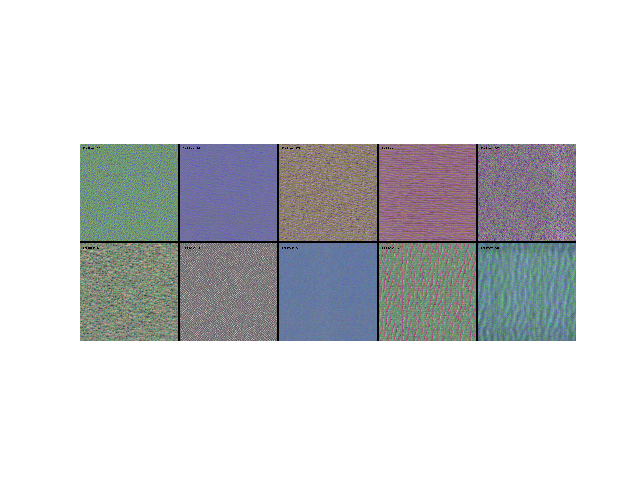
This second one gets a little bit more noisy, but some of them you can see differernt types of patterns like polka dots:
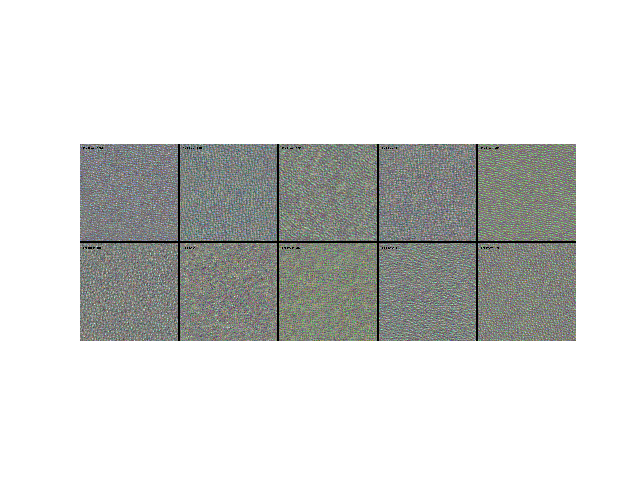
More advanced patterns are showing up now, still noisy though:
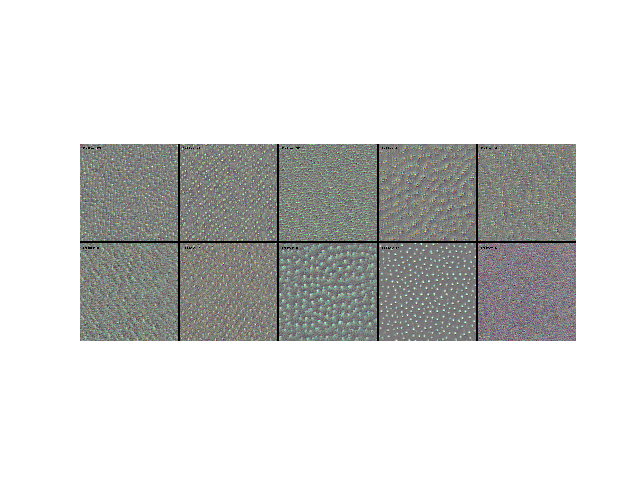
Mostly just noise here, this is likely due to us not performing enough backpropogation steps when generating the images:
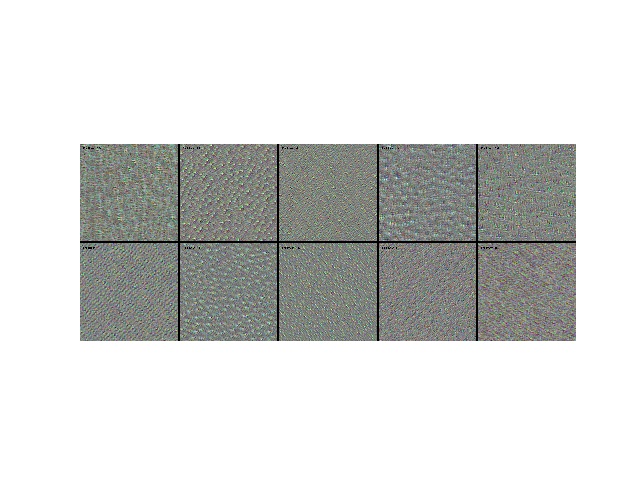